# Actividad

## Imports

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import pandas as pd
from tqdm.notebook import tqdm

## Utils

#### Cargar una imagen del dataset

In [0]:
def load_image(image_name, gray=False, crop=False):
    """Carga una imagen con open-cv."""
    if not image_name.endswith('.jpg'):
        image_name = f'{image_name}.jpg'
    
    image_path = f'data/full/{image_name}'
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if image is None:
        raise Exception(f'Cant load image: {image_name}')
    
    # open-cv loads as BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if crop:
        image = image[:128, :]

    return image

In [4]:
img = load_image('FM000020_03')
plt.imshow(img)
img.shape

Exception: ignored

#### Cargar un dataset de las N primeras imagenes de un dataset

In [0]:
def load_dataset(n_images, gray=True, crop=True):
    dataset = []
    image_base_name = 'F'
    for i_image in range(1, n_images+1):
        base_name = f'FM{i_image:06d}'

        for j in range(1, 6+1):
            # Load image
            image_name = f'{base_name}_{j:02d}'
            image = load_image(image_name, gray=gray, crop=crop)
            
            dataset.append((image, image_name, i_image, j))
            
    return dataset

In [0]:
datasetA = load_dataset(16)
len(datasetA)

96

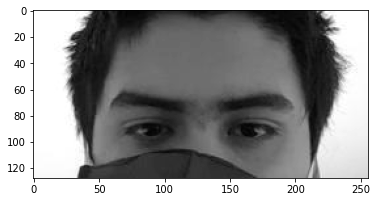

In [0]:
plt.imshow(datasetA[5][0], cmap='gray')

#### Plotear matriz de confusión

In [0]:
def plot_cm(cm, title='', labels=None, colorbar=False):
    """Plotear una matriz de confusion."""
    n_labels = len(cm)
    ticks = np.arange(n_labels)
    
    if labels is None:
        labels = ticks

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if colorbar:
        plt.colorbar()

    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')

    thresh = cm.max() / 2
    for row in range(n_labels):
        for col in range(n_labels):
            value = cm[row, col]
            color = 'white' if value > thresh else 'black'

            value_str = f'{int(value):d}'

            plt.text(col, row, value_str, ha='center', va='center', color=color)

## DataFrame con features

Se crea un `pd.DataFrame` que contendrá los features y las labels de cada imagen.


In [0]:
def create_df(dataset):
    # dataset has samples of: [image_cropped, image_name, i_image (label), j (image_number)]
    
    data = [sample[2:] for sample in dataset]
    image_names = [sample[1] for sample in dataset]
    df = pd.DataFrame(data, index=image_names, columns=['label', 'image_number'])
    
    return df

In [0]:
df_A = create_df(datasetA)
df_A.head(6)

,label,image_number
FM000001_01,1,1
FM000001_02,1,2
FM000001_03,1,3
FM000001_04,1,4
FM000001_05,1,5
FM000001_06,1,6


In [0]:
def calculate_feature_df(dataset, feature_fn, feature_name, **kwargs):
    print(f'Calculating {feature_name}')

    image_names = []
    features = []
    
    # Cargar imagenes y calcular vectores de features
    for sample in dataset:
        image = sample[0]
        image_names.append(sample[1])

        image_features = feature_fn(image, **kwargs)
        # print(len(image_features))
        features.append(image_features)
    
    features = np.array(features)
    # print(features.shape)
    n_images, n_feats = features.shape

    # Nombres de los features, e.g. 'hog_0', 'hog_1', etc
    columns = [f'{feature_name}_{idx}' for idx in range(n_feats)]
    
    # Crear DataFrame, el index son nombres de las imagenes
    feature_df = pd.DataFrame(features, index=image_names, columns=columns)
    
    # Retornar DataFrame con features calculados
    return feature_df

## Aplicar LBP

Se aplica LBP de la librería `skimage`.

In [0]:
from skimage.feature import local_binary_pattern

### Ejemplo

In [0]:
image = load_image('FM000020_03', gray=True, crop=True)
image.shape

(128, 256)

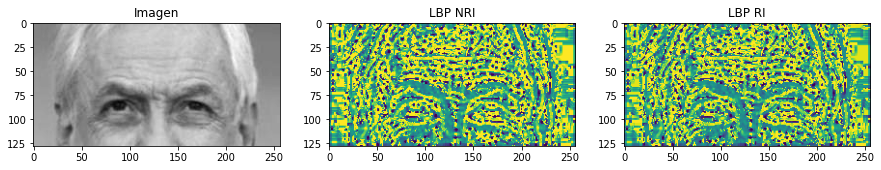

In [0]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Imagen')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('LBP NRI')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='nri_uniform'))

plt.subplot(1, 3, 3)
plt.title('LBP Rot-invariant')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='uniform'))

### Función para calcular histograma de LBP

In [0]:
def calculate_lbp(image, n_vertical=4, n_horizontal=8, radius=1, method='uniform'):
    """Se calcula LBP para una imagen, considerando crops horizontales y verticales."""
    
    global_features = []

    for horizontal_patch in np.array_split(image, n_horizontal, axis=1):
        for patch in np.array_split(horizontal_patch, n_vertical, axis=0):
            local_features = local_binary_pattern(patch, 8*radius, radius, method=method)

            # Computar histograma
            n_bins = int(local_features.max() + 1)
            lbp_hist, _ = np.histogram(local_features, bins=n_bins)
            
            global_features.append(lbp_hist)
            
    # Pad local_features to reach same size
    max_feature = max(len(arr) for arr in global_features)
    global_features = np.array([np.pad(arr, (0, max_feature - len(arr))) for arr in global_features])

    return global_features.flatten()

In [0]:
image = load_image('FM000020_03', gray=True, crop=True)
image.shape

(128, 256)

In [0]:
lbp = calculate_lbp(image, n_vertical=4, n_horizontal=8, method='nri_uniform')
len(lbp)

1888

Text(0.5, 1.0, 'Histogramas LBP concatenados')

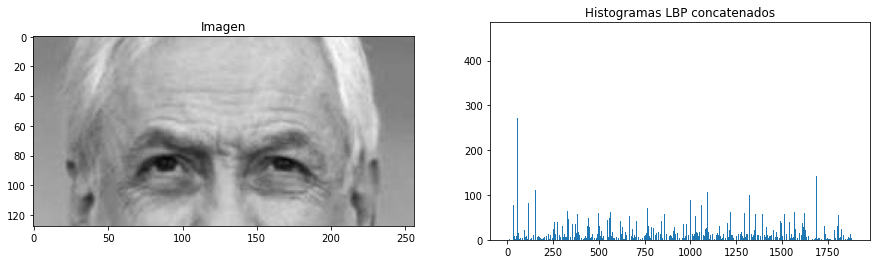

In [0]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen')

plt.subplot(1, 2, 2)
plt.bar(range(len(lbp)), lbp)
plt.title('Histogramas LBP concatenados')

### Calcular LBP para todo el dataset

In [0]:
lbp_df = calculate_feature_df(datasetA, calculate_lbp, 'lbp', radius=1, method='nri_uniform')
lbp_df.head()

Calculating lbp


,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,lbp_1878,lbp_1879,lbp_1880,lbp_1881,lbp_1882,lbp_1883,lbp_1884,lbp_1885,lbp_1886,lbp_1887
FM000001_01,24,9,0,6,1,18,0,9,0,2,...,3,0,14,1,5,0,5,4,355,37
FM000001_02,9,17,0,14,0,11,0,8,0,8,...,8,4,3,11,8,4,5,14,42,74
FM000001_03,30,6,0,20,0,8,0,32,0,7,...,7,20,6,6,7,12,5,5,55,91
FM000001_04,27,32,0,3,2,23,1,11,1,11,...,0,0,0,0,0,0,0,0,900,0
FM000001_05,29,16,0,4,1,20,1,2,2,1,...,0,0,1,0,9,0,4,0,686,8


##### Mergear con DF de labels

In [0]:
df_A = df_A.merge(lbp_df, right_index=True, left_index=True)
df_A.head()

,label,image_number,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,...,lbp_1878,lbp_1879,lbp_1880,lbp_1881,lbp_1882,lbp_1883,lbp_1884,lbp_1885,lbp_1886,lbp_1887
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,3,0,14,1,5,0,5,4,355,37
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,8,4,3,11,8,4,5,14,42,74
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,7,20,6,6,7,12,5,5,55,91
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0,0,0,0,0,0,0,0,900,0
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0,0,1,0,9,0,4,0,686,8


## Clasificación

In [0]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import accuracy_score, confusion_matrix

In [0]:
def split_train_val_test(df):
    train = df.loc[df['image_number'] < 4]
    val = df.loc[df['image_number'] == 4]
    test = df.loc[df['image_number'] > 4]
    return train, val, test

In [0]:
def run_experiment(dataset_df, method='KNN', **method_kwargs):
    # Seleccionar columnas
    train_cols = [f'lbp_{idx}' for idx in range(1888)]

    train, val, _ = split_train_val_test(dataset_df)

    x_train = train[train_cols]
    y_train = train['label']

    x_val = train[train_cols]
    y_val = train['label']
    
    # Elegir clasificador
    if method == 'KNN':
        ModelClass = KNN
    elif method == 'SVM':
        ModelClass = SVC
    elif method == 'MLP':
        ModelClass = MLP
    else:
        raise Exception(f'Unkwown model: {method}')
        
    # Entrenar clasificador
    print('Training...')
    model = ModelClass(**method_kwargs)
    model.fit(x_train, y_train)
    
    # Predecir para set de testing
    print('Predicting...')
    y_pred = model.predict(x_val)
    
    # Evaluar predicciones hechas
    print('Computing metrics...')
    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    print('Accuracy: ', accuracy)
    plot_cm(cm)

Training...
Predicting...
Computing metrics...
Accuracy:  0.6041666666666666


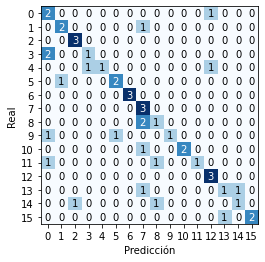

In [0]:
run_experiment(df_A, method='KNN', n_neighbors=5)